# Task 1: Creating the Database

## Connecting to PGAdmin

In [1]:
# Import all modules needed
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'

credentials = "Credentials.json"

# Function to connect to pgAdmin
def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

# Function used to query once data is loaded into pgAdmin
def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

# Connect to server
db, conn = pgconnect(credentials)

Connected successfully.


### Define out WKT function
This is used to make sure all our geometries are MultiPolygons and in WKT for PostGIS to be able to interpret them. We will also be using the SRID 4283 (GDA94) as per the SA2 Doc. City of Sydney DataHub uses 28356, which is still GDA94.

In [2]:
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

srid = 4283

## Cleaning the CSV Files
The first step of creating the database is to interpret the provided datasets and remove any unwanted or unnecassary columns or entries. This is achieved using the pandas library in python.

### Business Stats
This file contains data on the number of businesses in particular SA2 areas.

In [3]:
# Read file
businessstats = pd.read_csv('BusinessStats.csv')

# Dropping columns not needed in analysis (only need to consider accomodation, retail and health services)
businessstats = businessstats.drop(columns=['agriculture_forestry_and_fishing', 'agriculture_forestry_and_fishing',\
                                            'transport_postal_and_warehousing', 'public_administration_and_safety'])

# Renaming columns for readability
businessstats.rename(columns={'number_of_businesses':'no_of_businesses', 'accommodation_and_food_services':'accom_and_food',\
                              'health_care_and_social_assistance':'health_care'}, inplace=True)

# Print first 5 entries to show changes
businessstats.head()

,area_id,area_name,no_of_businesses,accom_and_food,retail_trade,health_care
0,101021007,Braidwood,629,26,27,11
1,101021008,Karabar,326,7,10,11
2,101021009,Queanbeyan,724,52,47,56
3,101021010,Queanbeyan - East,580,16,23,12
4,101021011,Queanbeyan Region,1642,39,63,34


### Neighbourhoods
This file contains data on the size, population and demographics of SA2 areas.

In [4]:
#Read file
neighbourhoods = pd.read_csv('Neighbourhoods.csv')

# Formatting columns to correct type
neighbourhoods['population'] = neighbourhoods.population.replace(',', '', regex=True)
neighbourhoods['population'] = pd.to_numeric(neighbourhoods.population)
neighbourhoods['number_of_dwellings'] = neighbourhoods.number_of_dwellings.replace(',', '', regex=True)
neighbourhoods['number_of_dwellings'] = pd.to_numeric(neighbourhoods.number_of_dwellings)

# Drop entries where population is Null or less than 1000 (small population will unfairly skew results)
neighbourhoods = neighbourhoods.dropna(subset='population')
neighbourhoods = neighbourhoods.drop(neighbourhoods[(neighbourhoods.population < 1000)].index)

# Drop entries where there are no dwellings
neighbourhoods = neighbourhoods.drop(neighbourhoods[neighbourhoods.number_of_dwellings == 0].index)

# Combine age groups into one young_people column
neighbourhoods['young_people'] = neighbourhoods['0-4'] + neighbourhoods['5-9'] + neighbourhoods['10-14'] + neighbourhoods['15-19']

# Replace all entries with 0 young people with NaN to prevent division by 0
neighbourhoods.young_people = neighbourhoods.young_people.replace(0, np.nan)

# Removing unnecessary columns (number of businesses in businessstats table)
neighbourhoods = neighbourhoods.drop(columns=['Unnamed: 0', '0-4', '5-9', '10-14', '15-19', 'number_of_businesses'])

# Rename columns for readability
neighbourhoods.rename(columns={'number_of_dwellings':'no_of_dwellings', 'median_annual_household_income':\
                               'median_annual_income'}, inplace=True)

# Print first 5 entries to show changes
neighbourhoods

,area_id,area_name,land_area,population,no_of_dwellings,median_annual_income,avg_monthly_rent,young_people
0,102011028,Avoca Beach - Copacabana,643.8000,7590.0,2325,46996.0,1906.0,2214
1,102011029,Box Head - MacMasters Beach,3208.6000,10986.0,3847,42621.0,1682.0,2635
2,102011030,Calga - Kulnura,76795.1000,4841.0,1575,42105.0,1182.0,1098
3,102011031,Erina - Green Point,3379.3000,14237.0,4450,43481.0,1595.0,3227
4,102011032,Gosford - Springfield,1691.2000,19385.0,6373,45972.0,1382.0,4219
...,...,...,...,...,...,...,...,...
317,106011109,Cessnock Region,1570.4341,7931.0,3281,73164.0,1080.0,2126
318,106011113,Singleton Region,4067.2349,4919.0,2055,87984.0,1000.0,1380
319,111021218,Morisset - Cooranbong,330.5208,14959.0,6298,58084.0,1260.0,3458
320,114021285,Hill Top - Colo Vale,174.3752,6025.0,2249,81120.0,1512.0,1864


## Cleaning Spatial Files
This step is much like thr process of cleaning the CSV files, but there is one extra step of changing the geometry data to a format that can be interpretted by PostGIS.

### SA2 Spatial Data
This file contains data on the size, name and geographic layout of SA2 areas.

In [5]:
# Read file
SA2 = gpd.read_file("SA2_2016_AUST/SA2_2016_AUST.shp")

# Drop entries with null values (only found in geometry column)
SA2 = SA2.dropna()

# Drop entries not in 'Greater Sydney'
SA2 = SA2.drop(SA2[~(SA2.GCC_NAME16 == 'Greater Sydney')].index)

# Drop columns not needed in analysis
SA2 = SA2.drop(columns=['SA2_5DIG16', 'SA3_CODE16', 'SA4_CODE16', 'SA4_NAME16', 'GCC_CODE16', 'STE_CODE16', \
                        'STE_NAME16', 'GCC_NAME16'])

# Make sure SA2_MAIN16 is an integer
SA2['SA2_MAIN16'] = pd.to_numeric(SA2.SA2_MAIN16)

# Create new column for geometries as WKT Multipolygons
SA2['geom'] = SA2['geometry'].apply(lambda x: create_wkt_element(geom=x, srid=srid))
SA2 = SA2.drop(columns='geometry')

# Rename columns for readability and to_sql() function
SA2.rename(columns={'SA2_MAIN16':'area_id', 'SA2_NAME16':'area_name', 'SA3_NAME16':'sa3_name', \
                    'AREASQKM16':'land_area'}, inplace=True)

# Remove rows from SA2 not in Neighbourhoods and vice versa
diffSA = []
for row in SA2['area_id'].values:
    if row not in neighbourhoods['area_id'].values:
        diffSA.append(row)
diffNE = []
for row in neighbourhoods['area_id'].values:
    if row not in SA2['area_id'].values:
        diffNE.append(row)
        
neighbourhoods = neighbourhoods[~neighbourhoods['area_id'].isin(diffNE)]
SA2 = SA2[~SA2['area_id'].isin(diffSA)]

SA2

,area_id,area_name,sa3_name,land_area,geom
27,102011028,Avoca Beach - Copacabana,Gosford,6.4376,MULTIPOLYGON (((151.4137275700001 -33.46559324...
28,102011029,Box Head - MacMasters Beach,Gosford,32.0860,MULTIPOLYGON (((151.3539836770001 -33.49854010...
29,102011030,Calga - Kulnura,Gosford,767.9512,MULTIPOLYGON (((151.20459505400004 -33.5329829...
30,102011031,Erina - Green Point,Gosford,33.7934,MULTIPOLYGON (((151.36794832200007 -33.4382241...
31,102011032,Gosford - Springfield,Gosford,16.9124,MULTIPOLYGON (((151.310060818 -33.426989095999...
...,...,...,...,...,...
570,128021536,Oyster Bay - Como - Jannali,Sutherland - Menai - Heathcote,8.9053,MULTIPOLYGON (((151.06905106200009 -33.9981750...
572,128021538,Sutherland - Kirrawee,Sutherland - Menai - Heathcote,7.7547,MULTIPOLYGON (((151.05049439000004 -34.0200584...
573,128021607,Engadine,Sutherland - Menai - Heathcote,8.9538,MULTIPOLYGON (((150.99567803200011 -34.0536210...
574,128021608,Loftus - Yarrawarrah,Sutherland - Menai - Heathcote,3.8436,MULTIPOLYGON (((151.03954278300012 -34.0417579...


In [6]:
neighbourhoods['geom'] = SA2['geom'].values
neighbourhoods

,area_id,area_name,land_area,population,no_of_dwellings,median_annual_income,avg_monthly_rent,young_people,geom
0,102011028,Avoca Beach - Copacabana,643.8,7590.0,2325,46996.0,1906.0,2214,MULTIPOLYGON (((151.4137275700001 -33.46559324...
1,102011029,Box Head - MacMasters Beach,3208.6,10986.0,3847,42621.0,1682.0,2635,MULTIPOLYGON (((151.3539836770001 -33.49854010...
2,102011030,Calga - Kulnura,76795.1,4841.0,1575,42105.0,1182.0,1098,MULTIPOLYGON (((151.20459505400004 -33.5329829...
3,102011031,Erina - Green Point,3379.3,14237.0,4450,43481.0,1595.0,3227,MULTIPOLYGON (((151.36794832200007 -33.4382241...
4,102011032,Gosford - Springfield,1691.2,19385.0,6373,45972.0,1382.0,4219,MULTIPOLYGON (((151.310060818 -33.426989095999...
...,...,...,...,...,...,...,...,...,...
306,128021536,Oyster Bay - Como - Jannali,890.5,22084.0,5931,55391.0,1947.0,6210,MULTIPOLYGON (((151.06905106200009 -33.9981750...
308,128021538,Sutherland - Kirrawee,775.5,21760.0,6924,53378.0,1809.0,4894,MULTIPOLYGON (((151.05049439000004 -34.0200584...
309,128021607,Engadine,895.4,17424.0,5219,52667.0,1955.0,5176,MULTIPOLYGON (((150.99567803200011 -34.0536210...
310,128021608,Loftus - Yarrawarrah,384.4,7426.0,2177,51243.0,2163.0,2054,MULTIPOLYGON (((151.03954278300012 -34.0417579...


### SA2 Spatial Data: City of Sydney Only
For task 2 we need to only include SA2 areas from Sydney's Inner City.

In [7]:
# Drop any entries not within SA3 area 'Sydney Inner City'
SA2_CoS = SA2.drop(SA2[~(SA2.sa3_name == 'Sydney Inner City')].index)

# Print whole table
SA2_CoS

,area_id,area_name,sa3_name,land_area,geom
339,117031329,Darlinghurst,Sydney Inner City,0.8569,MULTIPOLYGON (((151.2122688500001 -33.87632702...
340,117031330,Erskineville - Alexandria,Sydney Inner City,4.3200,MULTIPOLYGON (((151.1819960050001 -33.90065099...
341,117031331,Glebe - Forest Lodge,Sydney Inner City,2.3018,MULTIPOLYGON (((151.1827618850001 -33.87221312...
342,117031332,Newtown - Camperdown - Darlington,Sydney Inner City,3.2812,MULTIPOLYGON (((151.17255900400005 -33.8910904...
343,117031333,Potts Point - Woolloomooloo,Sydney Inner City,1.4591,MULTIPOLYGON (((151.2188622100001 -33.86862251...
344,117031334,Pyrmont - Ultimo,Sydney Inner City,1.4913,MULTIPOLYGON (((151.19359001100008 -33.8643650...
345,117031335,Redfern - Chippendale,Sydney Inner City,2.1631,MULTIPOLYGON (((151.19681150100007 -33.8907369...
346,117031336,Surry Hills,Sydney Inner City,1.3164,MULTIPOLYGON (((151.2083040010001 -33.88344000...
347,117031337,Sydney - Haymarket - The Rocks,Sydney Inner City,4.2934,MULTIPOLYGON (((151.22537899300005 -33.8552650...
348,117031338,Waterloo - Beaconsfield,Sydney Inner City,3.5809,MULTIPOLYGON (((151.2025828080001 -33.90453503...


### Break and Enter Data
This file contains data on the location and density of break and enter hotspots within Greater Sydney.

In [8]:
# Read file
break_and_enter = gpd.read_file("break_and_enter/BreakEnterDwelling_JanToDec2021.shp")

# Create new column for geometries as Multipolygons
break_and_enter['geom'] = break_and_enter['geometry'].apply(lambda x: create_wkt_element(geom=x, srid=srid))

#Drop columns not needed in analysis
break_and_enter = break_and_enter.drop(columns=['geometry', 'Contour', 'ORIG_FID'])

# Rename columns for readability and to_sql() function
break_and_enter.rename(columns={'OBJECTID':'objectid', 'Density':'density', 'Shape_Leng':'shape_leng', \
                                'Shape_Area':'shape_area'}, inplace=True)

# Print first 5 entries to show changes
break_and_enter.head()

,objectid,density,shape_leng,shape_area,geom
0,1,Low Density,0.012138,0.000006,MULTIPOLYGON (((149.91078014700008 -37.0663631...
1,2,Low Density,0.019106,0.000015,MULTIPOLYGON (((149.9060088220001 -37.05836717...
2,3,Low Density,0.006068,0.000002,MULTIPOLYGON (((148.94249939000008 -37.0420853...
3,4,Low Density,0.011006,0.000006,MULTIPOLYGON (((149.1958326340001 -36.91833255...
4,5,Low Density,0.008073,0.000003,MULTIPOLYGON (((149.84836006500007 -36.6845891...


### School Catchment Data
These files contain data on school's catchment areas, split between future, primary and secondary shool. It contains the school's name, the location and size of the catchment and what sort of school it is.

In [9]:
# Combine all three shape files into one dataframe
schools_future = gpd.read_file("school_catchments/catchments_future.shp")
schools_primary = gpd.read_file("school_catchments/catchments_primary.shp")
schools_secondary = gpd.read_file("school_catchments/catchments_secondary.shp")

# Added in new columns to check where the rows originated from (will remove when loading dilemma is fixed)
#schools_future['table'] = 'FUTURE'
#schools_primary['table'] = 'PRIMARY'
#schools_secondary['table'] = 'SECONDARY'

schools_all = pd.concat([schools_future, schools_primary, schools_secondary])

# Drop columns that are not needed (schools are either infant, primary or high school)
schools_all = schools_all.drop(columns=['ADD_DATE', 'KINDERGART', 'YEAR1', 'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6'])
schools_all = schools_all.drop(columns=['YEAR7', 'YEAR8', 'YEAR9', 'YEAR10', 'YEAR11', 'YEAR12' ,'PRIORITY'])

# Create new column for geometries as WKT Multipolygons
schools_all['geom'] = schools_all['geometry'].apply(lambda x: create_wkt_element(geom=x, srid=srid))
schools_all = schools_all.drop(columns='geometry')

# Replace school types with more common terms
schools_all = schools_all.replace(['HIGH_COED', 'CENTRAL_HIGH', 'HIGH_GIRLS', 'HIGH_BOYS'], 'HIGH')
schools_all = schools_all.replace(['CENTRAL_PRIMARY'], 'PRIMARY')

# Rename columns for readability and to_sql() function
schools_all.rename(columns={'USE_ID':'school_id', 'CATCH_TYPE':'school_type', 'USE_DESC':'school_name'}, inplace=True)

# Reset school_id to remove duplicates Primary Keys discovered from concatinating 3 tables
schools_all['school_id'] = range(1001, 1001+len(schools_all))

# Print first 5 entries to show changes
schools_all.head()

,school_id,school_type,school_name,geom
0,1001,PRIMARY,Harbord PS,MULTIPOLYGON (((151.29768576390327 -33.7683218...
1,1002,PRIMARY,Berinba PS,MULTIPOLYGON (((149.10301282737197 -34.8212654...
2,1003,PRIMARY,Murrumbateman PS,MULTIPOLYGON (((149.10556911272894 -34.8952307...
3,1004,PRIMARY,Manly Vale PS,MULTIPOLYGON (((151.27161704435014 -33.7691266...
4,1005,HIGH,Randwick BHS,MULTIPOLYGON (((151.27151530428182 -33.9140183...


### Extra dataset 1: Mobility Parking
For Task 2, we are using a dataset that includes data on the amount and location of Mobility Parking within the City of Sydney.

In [10]:
# Read file
mobility_parking = gpd.read_file("Mobility_parking/Mobility_parking.shp")

# Remove Z coordinate from POINT Z geometry
x = mobility_parking.geometry.x
y = mobility_parking.geometry.y
mobility_parking['geom'] = gpd.points_from_xy(x, y)

# Convert geometry to WKT POINT
mobility_parking['geom'] = mobility_parking['geom'].apply(lambda x: create_wkt_element(geom=x, srid=srid))

# Dropping columns that do not need in analysis
mobility_parking = mobility_parking.drop(columns=["geometry", "SiteID","Address","Street","Location","SideOfStre",\
                                                  "ParkingSpa","ParkingS_1","ParkingS_2","URL","AuditDate"])

# Replace empty value in SignText with "NAN"
mobility_parking = mobility_parking.replace(r'^\s*$', np.nan, regex = True)

# Rename columns for readability
mobility_parking.rename(columns={'OBJECTID':'objectid','Suburb':'suburb','SignText':'signtext',\
                                 'NumberPark':'no_of_parks'}, inplace = True)

# Check that changes take effect
mobility_parking.head()

,objectid,suburb,no_of_parks,signtext,geom
0,1,Dawes Point,2,None,POINT (151.207737645743 -33.8565395152761)
1,2,Erskineville,1,None,POINT (151.188402178523 -33.9026818665228)
2,3,Erskineville,1,None,POINT (151.181060862061 -33.9046212044313)
3,4,Haymarket,2,Managed by RailCorp,POINT (151.205381498052 -33.8825770410705)
4,5,Redfern,1,Rear to kerb parking,POINT (151.205208290857 -33.8944134463663)


### Extra dataset 2: Stairs
We also included a dataset on the location and size of staircases within City of Sydney.

In [11]:
# Read file
stairs = gpd.read_file("Stairs/Stairs.shp")

#Remove z coordinate from POINT Z
x = stairs.geometry.x
y = stairs.geometry.y
stairs['geom'] = gpd.points_from_xy(x, y)

# Convert geometry to WKT Point
stairs['geom'] = stairs['geom'].apply(lambda x: create_wkt_element(geom=x, srid=srid))

# Dropping unnecessary columns for analysis
stairs = stairs.drop(columns=["geometry", "ID", "ClosestAlt", "Photo", "Address", "TGSI", "StairNosin"])

# Rename columns for readbility
stairs.rename(columns={"OBJECTID":"objectid","No_Steps":"no_steps", "Name":"name", "Suburb":"suburb", \
                       "HandRails":"handrails"}, inplace = True)

stairs.head()

,objectid,name,suburb,no_steps,handrails,geom
0,1,Billyard Avenue Stairs East,Elizabeth Bay,15,Yes,POINT (151.226556499929 -33.8691898490496)
1,2,Barney and Bligh Reserve Steps,The Rocks,23,Yes,POINT (151.209137541716 -33.8587782128443)
2,3,Billyard Avenue Stairs West,Elizabeth Bay,30,Yes,POINT (151.226270249911 -33.869149649608)
3,4,Lincoln Crescent Stairs 3a,Woolloomooloo,47,Yes,POINT (151.219240438063 -33.8684191838832)
4,5,Fish Market Light Rail Stairs,Pyrmont,47,Yes,POINT (151.192429445079 -33.8707515522752)


## Creating SQL Tables and Populating
The dataframes created above need too be loaded into PGAdmin to allow for SQL queries to be performed on them and analysis to occur.

### Business Stats

In [12]:
createBusinessStatsTable = """
DROP TABLE IF EXISTS BusinessStats;
CREATE TABLE BusinessStats(
    area_id INTEGER PRIMARY KEY,
    area_name VARCHAR(64),
    no_of_businesses INTEGER,
    accom_and_food INTEGER,
    retail_trade  INTEGER,
    health_care INTEGER
);"""
conn.execute(createBusinessStatsTable)
businessstats.to_sql("businessstats", con=conn, if_exists='append', index=False)
query(conn, "select * from BusinessStats order by area_id limit 5")

,area_id,area_name,no_of_businesses,accom_and_food,retail_trade,health_care
0,101021007,Braidwood,629,26,27,11
1,101021008,Karabar,326,7,10,11
2,101021009,Queanbeyan,724,52,47,56
3,101021010,Queanbeyan - East,580,16,23,12
4,101021011,Queanbeyan Region,1642,39,63,34


### Neighbourhoods

In [13]:
createNeighbourhoodsTable = """
DROP TABLE IF EXISTS Neighbourhoods;
CREATE TABLE Neighbourhoods(
    area_id INTEGER PRIMARY KEY,
    area_name VARCHAR(64),
    land_area FLOAT,
    population FLOAT,
    no_of_dwellings INTEGER,
    median_annual_income FLOAT,
    avg_monthly_rent FLOAT,
    young_people FLOAT,
    geom GEOMETRY(MULTIPOLYGON, 4283)
);"""
conn.execute(createNeighbourhoodsTable)
neighbourhoods.to_sql("neighbourhoods", con=conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from Neighbourhoods Limit 5")

,area_id,area_name,land_area,population,no_of_dwellings,median_annual_income,avg_monthly_rent,young_people,geom
0,102011028,Avoca Beach - Copacabana,643.8,7590.0,2325,46996.0,1906.0,2214.0,0106000020BB100000010000000103000000010000005E...
1,102011029,Box Head - MacMasters Beach,3208.6,10986.0,3847,42621.0,1682.0,2635.0,0106000020BB1000000100000001030000000100000000...
2,102011030,Calga - Kulnura,76795.1,4841.0,1575,42105.0,1182.0,1098.0,0106000020BB1000000200000001030000000100000085...
3,102011031,Erina - Green Point,3379.3,14237.0,4450,43481.0,1595.0,3227.0,0106000020BB1000000100000001030000000100000041...
4,102011032,Gosford - Springfield,1691.2,19385.0,6373,45972.0,1382.0,4219.0,0106000020BB100000010000000103000000010000007F...


### Break and Enter

In [14]:
createBreakAndEnterTable = """
DROP TABLE IF EXISTS BreakAndEnter;
CREATE TABLE BreakAndEnter(
    objectid INTEGER PRIMARY KEY,
    density VARCHAR(20),
    shape_leng FLOAT,
    shape_area FLOAT,
    geom GEOMETRY(MULTIPOLYGON, 4283)
);"""
conn.execute(createBreakAndEnterTable)
break_and_enter.to_sql("breakandenter", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, 'select * from breakandenter limit 5')

,objectid,density,shape_leng,shape_area,geom
0,1,Low Density,0.012138,0.000006,0106000020BB1000000100000001030000000100000015...
1,2,Low Density,0.019106,0.000015,0106000020BB100000010000000103000000010000001D...
2,3,Low Density,0.006068,0.000002,0106000020BB1000000100000001030000000100000007...
3,4,Low Density,0.011006,0.000006,0106000020BB100000010000000103000000010000000E...
4,5,Low Density,0.008073,0.000003,0106000020BB100000010000000103000000010000000F...


### School Catchments

In [15]:
createSchoolTable = """
DROP TABLE IF EXISTS Schools;
CREATE TABLE Schools(
    school_id INTEGER PRIMARY KEY,
    school_type VARCHAR(10),
    school_name VARCHAR(40),
    geom GEOMETRY(MULTIPOLYGON, 4283)
);"""
conn.execute(createSchoolTable)
schools_all.to_sql("schools", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, 'select * from schools limit 5')

,school_id,school_type,school_name,geom
0,1001,PRIMARY,Harbord PS,0106000020BB1000000100000001030000000100000084...
1,1004,PRIMARY,Manly Vale PS,0106000020BB100000010000000103000000010000009D...
2,1005,HIGH,Randwick BHS,0106000020BB100000010000000103000000010000006F...
3,1006,PRIMARY,Manly WPS,0106000020BB1000000100000001030000000100000060...
4,1083,PRIMARY,Brisbania PS,0106000020BB100000010000000103000000010000001F...


### Mobility Parking

In [16]:
createMobilityParkingTable = """
DROP TABLE IF EXISTS MobilityParking;
CREATE TABLE MobilityParking(
    objectid INTEGER,
    suburb VARCHAR(20),
    no_of_parks INTEGER,
    signtext VARCHAR(100),
    geom GEOMETRY(POINT, 4283)
);"""
conn.execute(createMobilityParkingTable)
mobility_parking.to_sql("mobilityparking", conn, if_exists='append',index=False, dtype={'geom':Geometry("POINT",srid)})
query(conn, "select * from mobilityparking limit 5")

,objectid,suburb,no_of_parks,signtext,geom
0,1,Dawes Point,2,None,0101000020BB100000A8536BC9A5E66240D8EB3A16A3ED...
1,2,Erskineville,1,None,0101000020BB1000000C68016407E662402EB453148BF3...
2,3,Erskineville,1,None,0101000020BB10000067242640CBE562407926ACA0CAF3...
3,4,Haymarket,2,Managed by RailCorp,0101000020BB100000C72A387C92E6624093CCD348F8F0...
4,5,Redfern,1,Rear to kerb parking,0101000020BB1000002A43FA1091E662407A9FCA237CF2...


### Stairs

In [17]:
createStairsTable = """
DROP TABLE IF EXISTS Stairs;
CREATE TABLE Stairs(
    objectid INTEGER PRIMARY KEY,
    name VARCHAR(100),
    suburb VARCHAR(30),
    no_steps INTEGER,
    handrails VARCHAR(3),
    geom GEOMETRY(POINT, 4283)
);"""
conn.execute(createStairsTable)
stairs.to_sql("stairs", conn, if_exists="append", index=False, dtype={'geom': Geometry("POINT", srid)})
query(conn, "select * from stairs limit 5")

,objectid,name,suburb,no_steps,handrails,geom
0,1,Billyard Avenue Stairs East,Elizabeth Bay,15,Yes,0101000020BB10000085BC6AF33FE7624073D7EB9C41EF...
1,2,Barney and Bligh Reserve Steps,The Rocks,23,Yes,0101000020BB10000027C13641B1E662408057C971ECED...
2,3,Billyard Avenue Stairs West,Elizabeth Bay,30,Yes,0101000020BB1000009E6D1B9B3DE76240B732B44B40EF...
3,4,Lincoln Crescent Stairs 3a,Woolloomooloo,47,Yes,0101000020BB1000001FEE850404E76240A9FF1C5C28EF...
4,5,Fish Market Light Rail Stairs,Pyrmont,47,Yes,0101000020BB100000DBACCB6128E662404BFB6FC974EF...


### INDEXES
Indexes are created for each of the geom columns. This will allow the spatial joins to be performed much quicker than without them. 

In [18]:
query(conn, """
DROP INDEX IF EXISTS neighbourhood_geom;
DROP INDEX IF EXISTS break_and_enter_geom;
DROP INDEX IF EXISTS school_geom;
DROP INDEX IF EXISTS stairs_geom;
DROP INDEX IF EXISTS parking_geom;

CREATE INDEX neighbourhood_geom
ON neighbourhoods
USING GIST (geom);

CREATE INDEX break_and_enter_geom
ON breakandenter
USING GIST (geom);

CREATE INDEX school_geom
ON schools
USING GIST (geom);

CREATE INDEX stairs_geom
ON stairs
USING GIST (geom);

CREATE INDEX parking_geom
ON mobilityparking
USING GIST (geom);
""")

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


# Task 2: Greater Sydney Analysis

| Measure | Definition | Risk | Data Source |
| :---: | :---: | :---: | :---: | 
| school | number of schools catchment areas per 1000 ’young people’ | + | school_catchments.zip |
| accom | number of accommodation and food services per 1000 people | + | BusinessStats.csv |
| retail | number of retail services per 1000 people | + | BusinessStats.csv |
| crime | sum of hotspot areas divided by total area | – | break_and_enter.zip |
| health | number of health services per 1000 people | + | BusinessStats.csv |

### Neighbourhoods

In [19]:
neighbourhoods_sql = """
SELECT area_id, area_name, population, land_area, median_annual_income, avg_monthly_rent, geom
FROM Neighbourhoods
ORDER BY area_id;
"""
neighbourhoods_calc = pd.read_sql(neighbourhoods_sql, conn)
neighbourhoods_calc

,area_id,area_name,population,land_area,median_annual_income,avg_monthly_rent,geom
0,102011028,Avoca Beach - Copacabana,7590.0,643.8,46996.0,1906.0,0106000020BB100000010000000103000000010000005E...
1,102011029,Box Head - MacMasters Beach,10986.0,3208.6,42621.0,1682.0,0106000020BB1000000100000001030000000100000000...
2,102011030,Calga - Kulnura,4841.0,76795.1,42105.0,1182.0,0106000020BB1000000200000001030000000100000085...
3,102011031,Erina - Green Point,14237.0,3379.3,43481.0,1595.0,0106000020BB1000000100000001030000000100000041...
4,102011032,Gosford - Springfield,19385.0,1691.2,45972.0,1382.0,0106000020BB100000010000000103000000010000007F...
...,...,...,...,...,...,...,...
293,128021536,Oyster Bay - Como - Jannali,22084.0,890.5,55391.0,1947.0,0106000020BB10000001000000010300000001000000EF...
294,128021538,Sutherland - Kirrawee,21760.0,775.5,53378.0,1809.0,0106000020BB1000000100000001030000000100000089...
295,128021607,Engadine,17424.0,895.4,52667.0,1955.0,0106000020BB100000010000000103000000010000008E...
296,128021608,Loftus - Yarrawarrah,7426.0,384.4,51243.0,2163.0,0106000020BB10000001000000010300000001000000A1...


## School

In [20]:
school_sql = """
SELECT n.area_id, count(s.school_id)/(n.young_people/1000) as school_score
FROM Neighbourhoods n JOIN Schools s ON ST_intersects(n.geom, s.geom)
GROUP BY n.area_id
ORDER BY n.area_id;
"""
school_calc = pd.read_sql(school_sql, conn)
school_calc

,area_id,school_score
0,102011028,2.710027
1,102011029,3.036053
2,102011030,24.590164
3,102011031,5.268051
4,102011032,3.318322
...,...,...
293,128021536,2.576490
294,128021538,3.473641
295,128021607,2.511592
296,128021608,3.894839


## Accommodation

In [21]:
accom_sql = """
SELECT n.area_id, b.accom_and_food/(n.population/1000) as accom_score
FROM Neighbourhoods n JOIN BusinessStats b ON n.area_id = b.area_id
ORDER BY n.area_id;
"""
accom_calc = pd.read_sql(accom_sql, conn)
accom_calc

,area_id,accom_score
0,102011028,4.347826
1,102011029,2.093574
2,102011030,2.891964
3,102011031,4.776287
4,102011032,4.849110
...,...,...
293,128021536,2.354646
294,128021538,3.354779
295,128021607,2.123508
296,128021608,1.211958


## Retail

In [22]:
retail_sql = """
SELECT n.area_id, b.retail_trade/(n.population/1000) as retail_score
FROM Neighbourhoods n JOIN BusinessStats b ON n.area_id = b.area_id
ORDER BY n.area_id;
"""
retail_calc = pd.read_sql(retail_sql, conn)
retail_calc

,area_id,retail_score
0,102011028,4.611331
1,102011029,4.096122
2,102011030,8.882462
3,102011031,10.184730
4,102011032,8.614908
...,...,...
293,128021536,3.803659
294,128021538,5.193015
295,128021607,3.960055
296,128021608,2.693240


## Crime

In [23]:
crime_sql = """
SELECT n.area_id, count(c.objectid)/n.land_area as crime_score
FROM Neighbourhoods n JOIN BreakAndEnter c ON ST_intersects(n.geom, c.geom)
GROUP BY n.area_id
ORDER BY n.area_id;
"""
crime_calc = pd.read_sql(crime_sql, conn)
crime_calc

,area_id,crime_score
0,102011029,0.001247
1,102011031,0.001480
2,102011032,0.004139
3,102011033,0.001204
4,102011034,0.003309
...,...,...
274,128021534,0.004111
275,128021535,0.000599
276,128021536,0.004492
277,128021538,0.006447


## Health

In [24]:
health_sql = """
SELECT n.area_id, b.health_care/(n.population/1000) as health_score
FROM Neighbourhoods n JOIN BusinessStats b ON n.area_id = b.area_id
ORDER BY area_id;
"""
health_calc = pd.read_sql(health_sql, conn)
health_calc

,area_id,health_score
0,102011028,7.905138
1,102011029,3.914072
2,102011030,2.478827
3,102011031,12.572873
4,102011032,12.690224
...,...,...
293,128021536,4.165912
294,128021538,5.836397
295,128021607,4.706152
296,128021608,3.366550


## Livability Calculations

In [25]:
# Combining the created dataframes into one dataframe for analysis
result = pd.concat([neighbourhoods_calc, school_calc['school_score'], accom_calc['accom_score'], retail_calc['retail_score'],\
                    crime_calc['crime_score'], health_calc['health_score']], axis=1)

#
result['crime_score'] = result['crime_score'].fillna(0)
result['school_score'] = result['school_score'].fillna(0)

# Calculating the z-score for each factor
school_mean = result['school_score'].mean()
school_std = result['school_score'].std()
result['school_score'] = (result['school_score'] - school_mean)/school_std

accom_mean = result['accom_score'].mean()
accom_std = result['accom_score'].std()
result['accom_score'] = (result['accom_score'] - accom_mean)/accom_std

retail_mean = result['retail_score'].mean()
retail_std = result['retail_score'].std()
result['retail_score'] = (result['retail_score'] - retail_mean)/retail_std

crime_mean = result['crime_score'].mean()
crime_std = result['crime_score'].std()
result['crime_score'] = (result['crime_score'] - crime_mean)/crime_std

health_mean = result['health_score'].mean()
health_std = result['health_score'].std()
result['health_score'] = (result['health_score'] - health_mean)/health_std

# Calculating the final score to be entered into the sigmoid function
result['total'] = result['school_score'] + result['accom_score'] + result['retail_score'] - result['crime_score'] +\
                    result['health_score']

# Passing the total score into a sigmoid function to get livability score
result['sigmoid'] = 1/(1+np.exp(-(result['total'])))

# Display the areas within City of Sydney, ordered by livability
result = result[['area_id', 'area_name', 'population', 'land_area', 'median_annual_income', \
                'avg_monthly_rent', 'sigmoid', 'school_score', 'accom_score', 'retail_score', 'crime_score',\
                'health_score', 'total', 'geom']]
result

,area_id,area_name,population,land_area,median_annual_income,avg_monthly_rent,sigmoid,school_score,accom_score,retail_score,crime_score,health_score,total,geom
0,102011028,Avoca Beach - Copacabana,7590.0,643.8,46996.0,1906.0,0.723011,-0.347526,0.130115,-0.277592,-1.123549,0.330901,0.959447,0106000020BB100000010000000103000000010000005E...
1,102011029,Box Head - MacMasters Beach,10986.0,3208.6,42621.0,1682.0,0.375854,-0.248972,-0.474578,-0.386652,-1.096717,-0.493699,-0.507183,0106000020BB1000000100000001030000000100000000...
2,102011030,Calga - Kulnura,4841.0,76795.1,42105.0,1182.0,0.998685,6.266549,-0.260413,0.626528,-0.790391,-0.790237,6.632817,0106000020BB1000000200000001030000000100000085...
3,102011031,Erina - Green Point,14237.0,3379.3,43481.0,1595.0,0.981956,0.425731,0.245047,0.902193,-1.128467,1.295308,3.996747,0106000020BB1000000100000001030000000100000041...
4,102011032,Gosford - Springfield,19385.0,1691.2,45972.0,1382.0,0.946668,-0.163646,0.264582,0.569891,-0.886025,1.319554,2.876406,0106000020BB100000010000000103000000010000007F...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,128021536,Oyster Bay - Como - Jannali,22084.0,890.5,55391.0,1947.0,0.397588,-0.387892,-0.404547,-0.448561,-1.267142,-0.441666,-0.415524,0106000020BB10000001000000010300000001000000EF...
294,128021538,Sutherland - Kirrawee,21760.0,775.5,53378.0,1809.0,0.682047,-0.116695,-0.136265,-0.154460,-1.267142,-0.096524,0.763197,0106000020BB1000000100000001030000000100000089...
295,128021607,Engadine,17424.0,895.4,52667.0,1955.0,0.412796,-0.407510,-0.466548,-0.415455,-1.267142,-0.330046,-0.352417,0106000020BB100000010000000103000000010000008E...
296,128021608,Loftus - Yarrawarrah,7426.0,384.4,51243.0,2163.0,0.326571,0.010627,-0.711067,-0.683616,-1.267142,-0.606823,-0.723737,0106000020BB10000001000000010300000001000000A1...


### Top 10 Most Livable Areas

In [26]:
final = result[['area_id', 'area_name', 'sigmoid']]
final.sort_values('sigmoid', ascending=False).head(10)

,area_id,area_name,sigmoid
79,117031337,Sydney - Haymarket - The Rocks,1.000000
99,119011355,Chullora,1.000000
71,117031329,Darlinghurst,0.999964
167,121041417,North Sydney - Lavender Bay,0.999945
149,121011401,St Leonards - Naremburn,0.999429
78,117031336,Surry Hills,0.999248
2,102011030,Calga - Kulnura,0.998685
83,118011341,Bondi Junction - Waverly,0.996477
182,122031432,Terrey Hills - Duffys Forest,0.993600
34,115011553,Castle Hill - Central,0.992633


### Most Unlivable Suburbs

In [27]:
final.sort_values('sigmoid').head(10)

,area_id,area_name,sigmoid
217,124051470,St Clair,0.012168
90,118021350,Malabar - La Perouse - Chifley,0.015050
61,116031315,Hassall Grove - Plumpton,0.016713
65,117011321,Botany,0.020470
82,118011340,Bondi Beach - North Bondi,0.021451
207,124031460,Glenmore Park - Regentville,0.021748
255,127011504,Ashcroft - Busby - Miller,0.025996
62,116031316,Lethbridge Park - Tregear,0.026425
235,125031484,Guildford West - Merrylands West,0.028619
218,124051580,Colyton - Oxley Park,0.033160


## Plot sydney

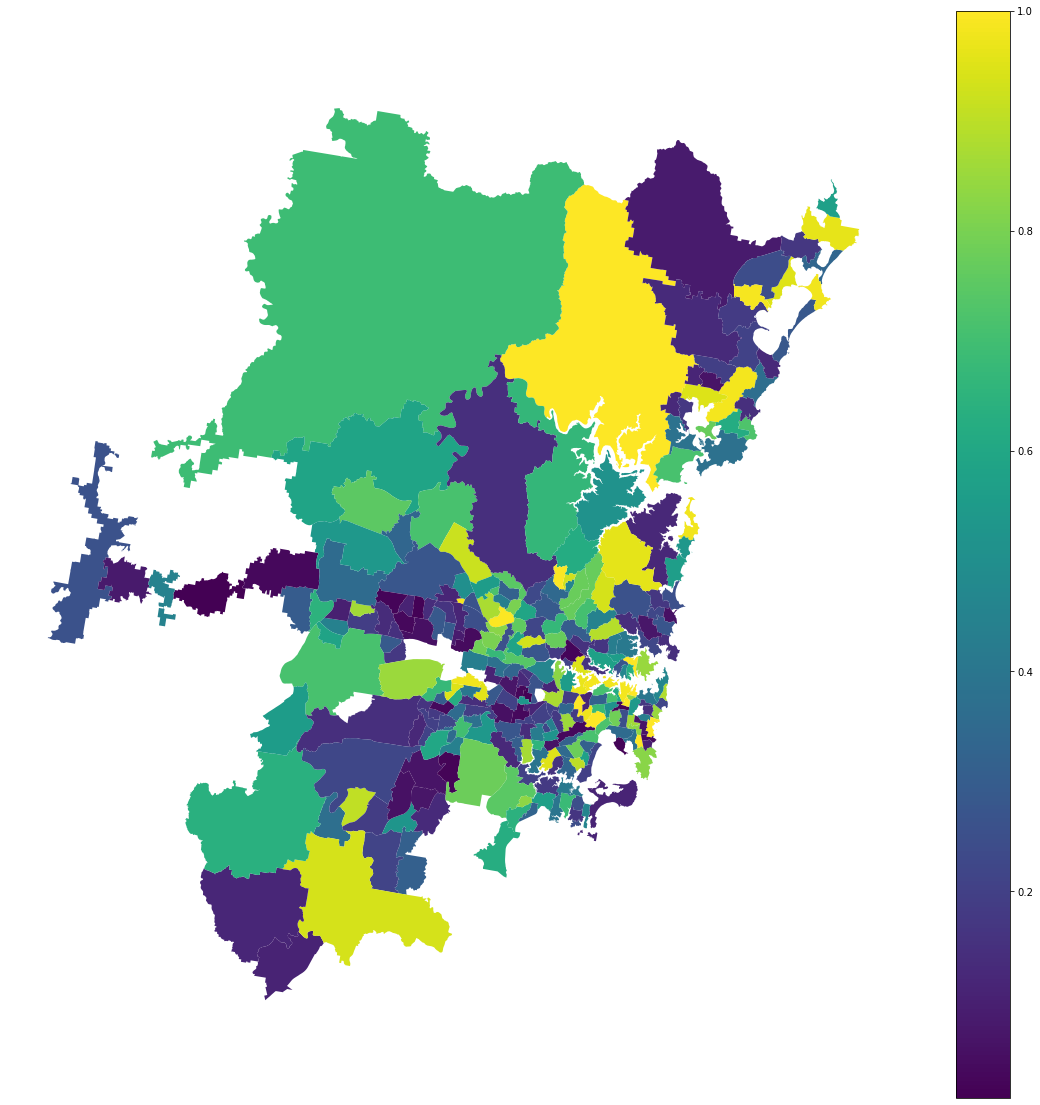

In [28]:
sydneyplot = gpd.read_postgis("SELECT area_id, geom FROM Neighbourhoods", conn)
sydneyplot['sigmoid'] = result['sigmoid']
sydneyplot = sydneyplot.plot(figsize=(20, 20), column=('sigmoid'), legend=True)
sydneyplot.set_axis_off()

## Correlation between Rent, Income and Livability

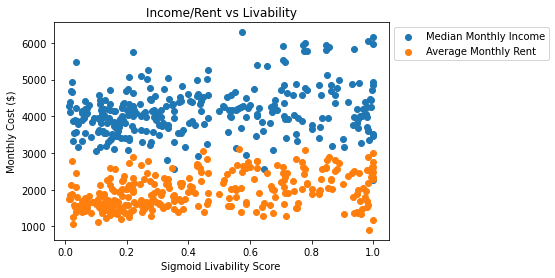

In [29]:
correlation = result[['area_id', 'area_name', 'median_annual_income', 'avg_monthly_rent', 'sigmoid']]

# Change median_annual_income to median_monthly_income to allow for better visualisaton on graph
correlation['median_annual_income'] = correlation['median_annual_income']/12
correlation.rename(columns={'median_annual_income':'median_monthly_income'}, inplace=True)

plt.scatter(correlation['sigmoid'], correlation['median_monthly_income'])
plt.scatter(correlation['sigmoid'], correlation['avg_monthly_rent'])
plt.legend(['Median Monthly Income', 'Average Monthly Rent'], bbox_to_anchor=(1, 1))
plt.title('Income/Rent vs Livability')
plt.xlabel('Sigmoid Livability Score')
plt.ylabel('Monthly Cost ($)')
plt.rcParams['figure.figsize'] = [9, 9]
plt.show()

# Task 3: City of Sydney Analysis

## Stakeholder
Our stakeholder is a disabled international student who is decided to move to
Sydney in July. She has asked us to help her to find an area has the most accessible
infrastructure in the city of Sydney since they could provide great convenience to
her life. After receiving her proposal, we thought we could build on our previous
research by adding data of stairs and mobility parking.

| Measure | Definition | Risk | Data Source |
| :---: | :---: | :---: | :---: | 
| school | number of schools catchment areas per 1000 ’young people’ | + | school_catchments.zip |
| accom | number of accommodation and food services per 1000 people | + | BusinessStats.csv |
| retail | number of retail services per 1000 people | + | BusinessStats.csv |
| crime | sum of hotspot areas divided by total area | – | break_and_enter.zip |
| health | number of health services per 1000 people | + | BusinessStats.csv |
| stairs | number of staircases divided by total area | - | Stairs.zip |
| parking | number of mobility parking spaces divided by total area | + | Mobility_Parking.zip |
| rent | average monthly rent | - | Neighbourhoods.csv |

## Cleaning Neighbourhoods to only include City of Sydney areas

In [30]:
SA_COS = SA2.drop(SA2[~(SA2.sa3_name == 'Sydney Inner City')].index)

diffNECOS = []
for row in neighbourhoods['area_id'].values:
    if row not in SA_COS['area_id'].values:
        diffNECOS.append(row)
        
NE_COS = neighbourhoods[~neighbourhoods['area_id'].isin(diffNECOS)]

# Change units of land area to be same as found in SA2 dataset
NE_COS['land_area'] = NE_COS['land_area']/100

createCityOfSydneyTable = """
DROP TABLE IF EXISTS CityOfSydney;
CREATE TABLE CityOfSydney(
    area_id INTEGER PRIMARY KEY,
    area_name VARCHAR(64),
    land_area FLOAT,
    population FLOAT,
    no_of_dwellings INTEGER,
    median_annual_income FLOAT,
    avg_monthly_rent FLOAT,
    young_people FLOAT,
    geom GEOMETRY(MULTIPOLYGON, 4283)
);"""
conn.execute(createCityOfSydneyTable)
NE_COS.to_sql("cityofsydney", con=conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from CityOfSydney")

,area_id,area_name,land_area,population,no_of_dwellings,median_annual_income,avg_monthly_rent,young_people,geom
0,117031329,Darlinghurst,0.857,12414.0,3914,59293.0,2491.0,818.0,0106000020BB10000001000000010300000001000000A8...
1,117031330,Erskineville - Alexandria,4.320,17822.0,4374,69680.0,2581.0,2252.0,0106000020BB100000010000000103000000010000000A...
2,117031331,Glebe - Forest Lodge,2.302,21592.0,5073,56691.0,2162.0,2726.0,0106000020BB1000000100000001030000000100000008...
3,117031332,Newtown - Camperdown - Darlington,3.281,27450.0,5079,58210.0,2270.0,4049.0,0106000020BB1000000100000001030000000100000014...
4,117031333,Potts Point - Woolloomooloo,1.459,23809.0,8751,58253.0,2256.0,1449.0,0106000020BB10000001000000010300000001000000B1...
5,117031334,Pyrmont - Ultimo,1.491,24083.0,7599,47393.0,2575.0,2815.0,0106000020BB1000000100000001030000000100000027...
6,117031335,Redfern - Chippendale,2.163,25538.0,7230,51347.0,2193.0,2532.0,0106000020BB100000010000000103000000010000003F...
7,117031336,Surry Hills,1.316,18064.0,5040,58396.0,2342.0,1260.0,0106000020BB10000001000000010300000001000000A2...
8,117031337,Sydney - Haymarket - The Rocks,4.293,31010.0,8963,27311.0,2998.0,2617.0,0106000020BB100000030000000103000000010000000E...
9,117031338,Waterloo - Beaconsfield,3.581,37929.0,12544,57055.0,2302.0,5215.0,0106000020BB10000001000000010300000001000000F7...


## City of Sydney

In [31]:
cityofsydney_sql = """
SELECT area_id, area_name, population, land_area as land_area, median_annual_income, avg_monthly_rent, geom
FROM CityOfSydney
ORDER BY area_id;
"""
cityofsydney_calc = pd.read_sql(cityofsydney_sql, conn)
cityofsydney_calc

,area_id,area_name,population,land_area,median_annual_income,avg_monthly_rent,geom
0,117031329,Darlinghurst,12414.0,0.857,59293.0,2491.0,0106000020BB10000001000000010300000001000000A8...
1,117031330,Erskineville - Alexandria,17822.0,4.320,69680.0,2581.0,0106000020BB100000010000000103000000010000000A...
2,117031331,Glebe - Forest Lodge,21592.0,2.302,56691.0,2162.0,0106000020BB1000000100000001030000000100000008...
3,117031332,Newtown - Camperdown - Darlington,27450.0,3.281,58210.0,2270.0,0106000020BB1000000100000001030000000100000014...
4,117031333,Potts Point - Woolloomooloo,23809.0,1.459,58253.0,2256.0,0106000020BB10000001000000010300000001000000B1...
5,117031334,Pyrmont - Ultimo,24083.0,1.491,47393.0,2575.0,0106000020BB1000000100000001030000000100000027...
6,117031335,Redfern - Chippendale,25538.0,2.163,51347.0,2193.0,0106000020BB100000010000000103000000010000003F...
7,117031336,Surry Hills,18064.0,1.316,58396.0,2342.0,0106000020BB10000001000000010300000001000000A2...
8,117031337,Sydney - Haymarket - The Rocks,31010.0,4.293,27311.0,2998.0,0106000020BB100000030000000103000000010000000E...
9,117031338,Waterloo - Beaconsfield,37929.0,3.581,57055.0,2302.0,0106000020BB10000001000000010300000001000000F7...


## School

In [32]:
cosschool_sql = """
SELECT n.area_id, count(s.school_id)/(n.young_people/1000) as school_score
FROM CityOfSydney n JOIN Schools s ON ST_intersects(n.geom, s.geom)
GROUP BY n.area_id
ORDER BY n.area_id;
"""
cosschool_calc = pd.read_sql(cosschool_sql, conn)

## Accommodation

In [33]:
cosaccom_sql = """
SELECT n.area_id, b.accom_and_food/(n.population/1000) as accom_score
FROM CityOfSydney n JOIN BusinessStats b ON n.area_id = b.area_id
ORDER BY n.area_id;
"""
cosaccom_calc = pd.read_sql(cosaccom_sql, conn)

## Retail

In [34]:
cosretail_sql = """
SELECT n.area_id, b.retail_trade/(n.population/1000) as retail_score
FROM CityOfSydney n JOIN BusinessStats b ON n.area_id = b.area_id
ORDER BY n.area_id;
"""
cosretail_calc = pd.read_sql(cosretail_sql, conn)

## Crime

In [35]:
coscrime_sql = """
SELECT n.area_id, count(c.objectid)/n.land_area as crime_score
FROM CityOfSydney n JOIN BreakAndEnter c ON ST_intersects(n.geom, c.geom)
GROUP BY n.area_id
ORDER BY n.area_id;
"""
coscrime_calc = pd.read_sql(coscrime_sql, conn)

## Health

In [36]:
coshealth_sql = """
SELECT n.area_id, b.health_care/(n.population/1000) as health_score
FROM CityOfSydney n JOIN BusinessStats b ON n.area_id = b.area_id
ORDER BY area_id;
"""
coshealth_calc = pd.read_sql(coshealth_sql, conn)

## Stairs

In [37]:
cosstairs_sql = """
SELECT n.area_id, count(s.objectid)/n.land_area as stairs_score
FROM CityOfSydney n JOIN Stairs s ON ST_intersects(n.geom, s.geom)
GROUP BY n.area_id
ORDER BY n.area_id
"""
cosstairs_calc = pd.read_sql(cosstairs_sql, conn)
cosstairs_calc

,area_id,stairs_score
0,117031329,26.837806
1,117031330,2.314815
2,117031331,22.154648
3,117031332,10.057909
4,117031333,21.932831
5,117031334,35.546613
6,117031335,3.698567
7,117031336,7.598784
8,117031337,65.222455
9,117031338,4.188774


## Mobility Parking

In [38]:
cosparking_sql = """
SELECT n.area_id, sum(p.no_of_parks)/n.land_area as parking_score
FROM CityOfSydney n JOIN MobilityParking p ON ST_intersects(n.geom, p.geom)
GROUP BY n.area_id
ORDER BY n.area_id
"""
cosparking_calc = pd.read_sql(cosparking_sql, conn)
cosparking_calc

,area_id,parking_score
0,117031329,17.502917
1,117031330,4.166667
2,117031331,26.498697
3,117031332,10.667479
4,117031333,10.281014
5,117031334,12.072435
6,117031335,8.784096
7,117031336,10.638298
8,117031337,17.703238
9,117031338,2.792516


## Calculating adjusted livability score

In [39]:
cosresult = pd.concat([cityofsydney_calc, cosschool_calc['school_score'], cosaccom_calc['accom_score'],\
                       cosretail_calc['retail_score'], coscrime_calc['crime_score'], coshealth_calc['health_score'],\
                       cosstairs_calc['stairs_score'], cosparking_calc['parking_score']], axis=1)

# Calculating the z-score for each factor
# Based off stakeholder, we want to adjust the previous scores as per their relevance
school_mean = cosresult['school_score'].mean()
school_std = cosresult['school_score'].std()
cosresult['school_score'] = ((cosresult['school_score'] - school_mean)/school_std)*0.1

accom_mean = cosresult['accom_score'].mean()
accom_std = cosresult['accom_score'].std()
cosresult['accom_score'] = ((cosresult['accom_score'] - accom_mean)/accom_std)*0.1

retail_mean = cosresult['retail_score'].mean()
retail_std = cosresult['retail_score'].std()
cosresult['retail_score'] = ((cosresult['retail_score'] - retail_mean)/retail_std)*1.0

crime_mean = cosresult['crime_score'].mean()
crime_std = cosresult['crime_score'].std()
cosresult['crime_score'] = ((cosresult['crime_score'] - crime_mean)/crime_std)*1.0

health_mean = cosresult['health_score'].mean()
health_std = cosresult['health_score'].std()
cosresult['health_score'] = ((cosresult['health_score'] - health_mean)/health_std)*1.5

stairs_mean = cosresult['stairs_score'].mean()
stairs_std = cosresult['stairs_score'].std()
cosresult['stairs_score'] = ((cosresult['stairs_score'] - stairs_mean)/stairs_std)*1.8

parking_mean = cosresult['parking_score'].mean()
parking_std = cosresult['parking_score'].std()
cosresult['parking_score'] = ((cosresult['parking_score'] - parking_mean)/parking_std)*1.8

# Additional factor of monthly rent added
rent_mean = cosresult['avg_monthly_rent'].mean()
rent_std = cosresult['avg_monthly_rent'].std()
cosresult['rent_score'] = ((cosresult['avg_monthly_rent'] - rent_mean)/rent_std)*1.2

# Calculating the final score to be entered into the sigmoid function
cosresult['total'] = cosresult['school_score'] + cosresult['accom_score'] + cosresult['retail_score'] -\
                    cosresult['crime_score'] + cosresult['health_score'] - cosresult['stairs_score'] +\
                    cosresult['parking_score'] - cosresult['rent_score']

# Passing the total score into a sigmoid function to get livability score
cosresult['sigmoid'] = 1/(1+np.exp(-(cosresult['total'])))

# Display the areas within City of Sydney, ordered by livability
cosresult[['area_name','sigmoid', 'school_score', 'accom_score', 'retail_score', 'crime_score',\
                'health_score', 'stairs_score', 'parking_score', 'rent_score', 'total']].sort_values('sigmoid', ascending=False)

,area_name,sigmoid,school_score,accom_score,retail_score,crime_score,health_score,stairs_score,parking_score,rent_score,total
2,Glebe - Forest Lodge,0.985756,-0.072399,-0.053867,-0.545098,-0.730571,-0.549249,0.202992,3.721045,-1.209070,4.237081
8,Sydney - Haymarket - The Rocks,0.937379,-0.036627,0.275769,2.769011,-1.478832,3.705483,4.178038,1.446345,2.754782,2.705992
3,Newtown - Camperdown - Darlington,0.831129,-0.034347,-0.042243,-0.504768,-0.834656,0.103108,-0.913505,-0.373258,-0.696993,1.593647
7,Surry Hills,0.647121,0.098570,0.011201,-0.007640,0.478254,-0.132751,-1.140476,-0.380805,-0.355609,0.606406
6,Redfern - Chippendale,0.547963,0.054246,-0.053897,-0.556111,-0.054529,-1.008521,-1.500456,-0.860343,-1.062085,0.192443
0,Darlinghurst,0.489767,0.217020,0.014478,-0.095627,1.989809,1.404567,0.635235,1.394538,0.350867,-0.040936
4,Potts Point - Woolloomooloo,0.196915,0.024382,-0.034953,-0.511089,0.201641,-0.790034,0.182519,-0.473206,-0.763373,-1.405686
1,Erskineville - Alexandria,0.191174,-0.061369,-0.039017,0.075949,-0.624505,-0.838530,-1.628173,-2.054512,0.777598,-1.442400
9,Waterloo - Beaconsfield,0.108557,-0.103938,-0.050577,-0.320423,0.076055,-1.145151,-1.455211,-2.409898,-0.545267,-2.105565
5,Pyrmont - Ultimo,0.012856,-0.085539,-0.026893,-0.304205,0.977334,-0.748923,1.439036,-0.009906,0.749149,-4.340983


## Plotting livability in City Of Sydney

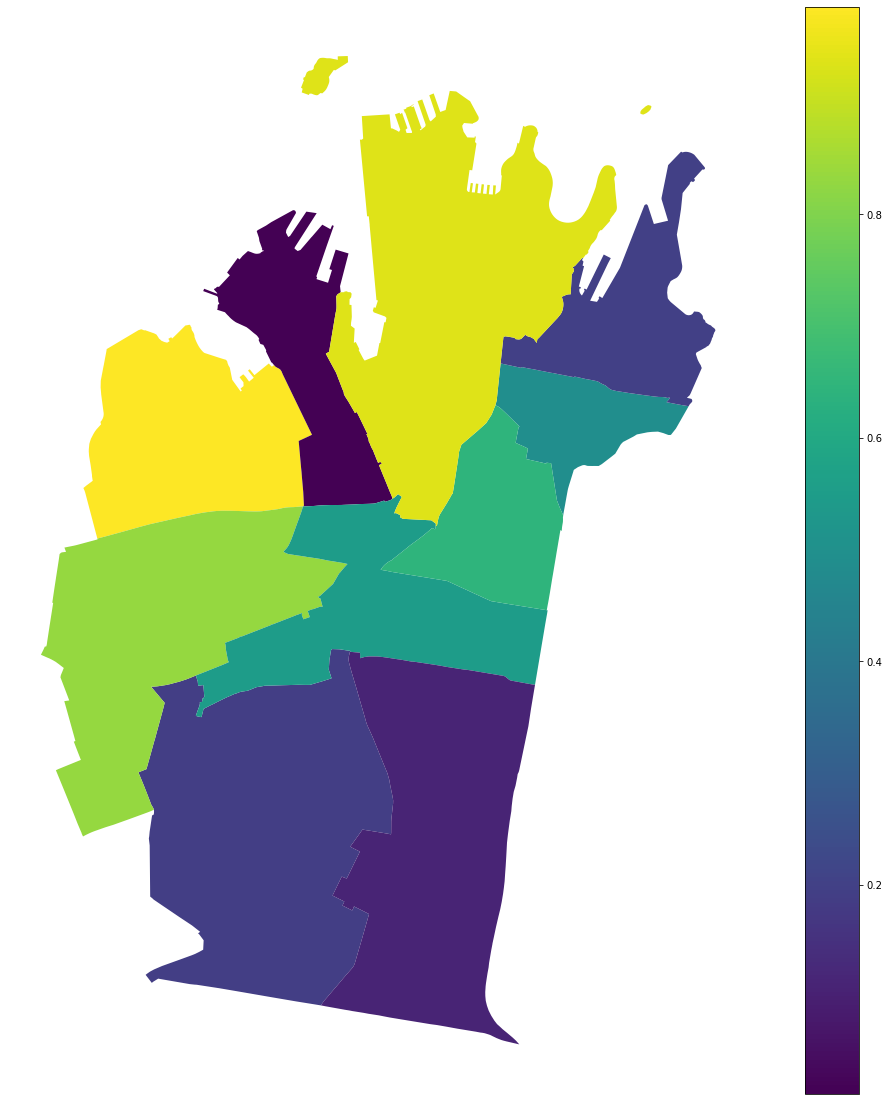

In [40]:
cityofsydneyplot = gpd.read_postgis("SELECT area_id, geom FROM CityOfSydney", conn)
cityofsydneyplot['sigmoid'] = cosresult['sigmoid']
cityofsydneyplot = cityofsydneyplot.plot(figsize=(20, 20), column=('sigmoid'), legend=True)
cityofsydneyplot.set_axis_off()

In [41]:
conn.close()
db.dispose()